In [63]:
using PyPlot

In [64]:
x_data = collect(linspace(0., 10.))
y_data = zeros(length(x_data))
sigma = 10.0
y_error = ones(length(x_data))*sigma
for idx=1:length(x_data)
    dev = 2.*sigma*rand() - 1.0
    y_data[idx] = x_data[idx]^2 + dev
end

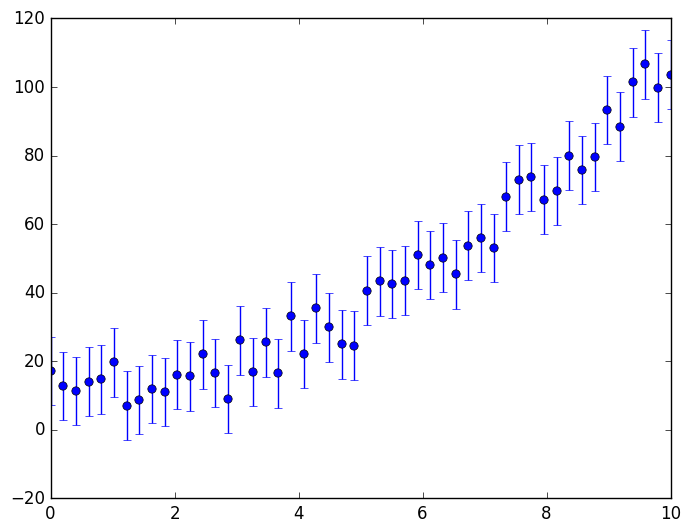

(PyObject <matplotlib.lines.Line2D object at 0x7f99cfa03f10>,(PyObject <matplotlib.lines.Line2D object at 0x7f99d2e41a90>,PyObject <matplotlib.lines.Line2D object at 0x7f99d2e71d50>),(PyObject <matplotlib.collections.LineCollection object at 0x7f99d2e414d0>,))

In [65]:
errorbar(x_data, y_data, y_error, fmt="o", label="Data")

In [66]:
function parabola_model(x, p)
    a = p[1]
    b = p[2]
    c = p[3]
    return a*x.^2 + b*x + c
end

parabola_model (generic function with 1 method)

In [67]:
lsq_fit_params = [1.2, 0.3, -0.2]
param_errors = [1.0, 1.0, 1.0]
y_model = zeros(length(x_data))
for idx=1:length(x_data)
    y_model[idx] = parabola_model(x_data[idx], lsq_fit_params)
end

chi_best = sum(((y_data-y_model)/y_error)^2)

1.4612533686303784

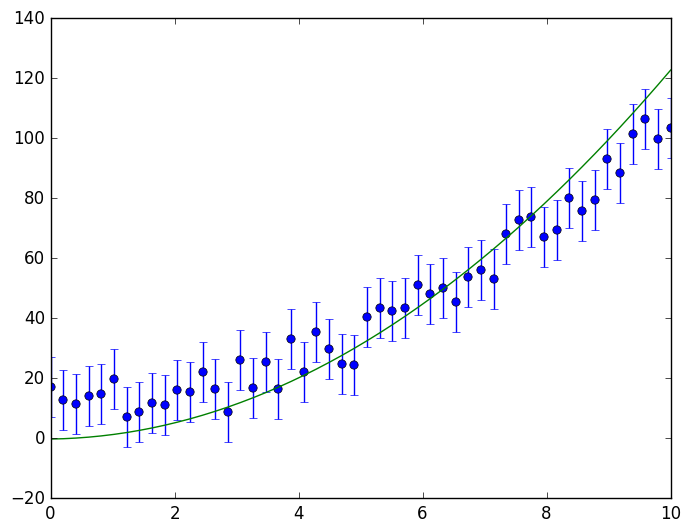

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f99cf8c9910>

In [68]:
errorbar(x_data, y_data, y_error, fmt="o", label="Data")
plot(x_data,y_model)

In [94]:
"""
# Finds the best fit paramaters for a model using an 
# affine-invariant markov chain:
# Foreman-Mackey et al. (2014) - 'emc' 'mcmc hammer'
#
# Input:
#           model: A function to model the data
#               x: The x values of the data
#               y: The y values of the data
#         y_error: Y value error bars
#  lsq_fit_params: Best fit parameters from doing a
#                  least squares fit
#    param_errors: Errors on the least squares fit  parameters
#        chi_best: Chi squared value from least squares fit
#
# Output:
#   param_mean: Mean value of the parameters found using MCMC
#    param_std: Standard deviation of the mean values
"""
function mcmc_fit!(model, x::Vector, y::Vector, y_error::Vector, lsq_fit_params::Vector, 
                   param_errors::Vector, chi_best::Float64, param_mean::Vector, param_std::Vector)  
    nparam = length(lsq_fit_params)
    nwalkers = nparam * 3
    nsteps = 10000
    # Set up arrays to hold the results:
    par_mcmc = zeros(nwalkers,nsteps,nparam)
    chi_mcmc = zeros(nwalkers,nsteps)
    # Initialize walkers:
    par_trial = lsq_fit_params
    for j=1:nwalkers
        # Select from within uncertainties:
        chi_trial = 1e100
        # Only initiate models with reasonable chi-square values:
        while chi_trial > (chi_best + 1000)
            par_trial = lsq_fit_params + param_errors.*randn(nparam)
            y_model = model(x, par_trial)
            chi_trial = sum(((y-y_model)./y_error).^2)
        end
        chi_mcmc[j,1]=chi_trial
        par_mcmc[j,1,:]=par_trial
        println("Success: ",par_trial,chi_trial)
    end
    
    # Initialize scale length & acceptance counter:
    ascale = 2.0
    accept = 0
    # Next, loop over steps in markov chain:
    for i=2:nsteps
        for j=1:nwalkers
            ipartner = j
            # Choose another walker to 'breed' a trial step with:
            while ipartner == j
                ipartner = ceil(Int,rand()*nwalkers)
            end
            # Now, choose a new set of parameters for the trial step:
            z=(rand()*(sqrt(ascale)-1.0/sqrt(ascale))+1.0/sqrt(ascale))^2
            par_trial=vec(z*par_mcmc[j,i-1,:]+(1.0-z)*par_mcmc[ipartner,i-1,:])
            # Compute model & chi-square:    
            y_model_trial = model(x,par_trial)
            chi_trial = sum(((y-y_model_trial)./y_error).^2)
            # Next, determine whether to accept this trial step:
            alp = z^(nparam-1)*exp(-0.5*(chi_trial - chi_mcmc[j,i-1]))
            if alp >= rand()
                # If step is accepted, add it to the chains!
                par_mcmc[j,i,:] = par_trial
                chi_mcmc[j,i,:] = chi_trial
                accept = accept + 1
            else
                # If step is rejected, then copy last step:
                par_mcmc[j,i,:] = par_mcmc[j,i-1,:]
                chi_mcmc[j,i,:] = chi_mcmc[j,i-1]
            end
        end
        if mod(i,1000) == 0
            frac_acc = accept/(1000*nwalkers)
            println("Number of steps: ",i," acceptance rate: ",frac_acc)
            ascale = 1.0 + (frac_acc/0.25)*(ascale-1.0)
            accept = 0
        end
    end
    
    # Now, determine time of burn-in by calculating first time median is crossed:
    iburn = 0
    for i=1:nparam
      med_param=median(par_mcmc[1:nwalkers,1:nsteps,i])
      for j=1:nwalkers
        istep=2
        while (par_mcmc[j,istep,i] > med_param) == (par_mcmc[j,istep-1,i] > med_param) && (istep < nsteps)
          istep=istep+1
        end
        if istep >= iburn
          iburn = istep
        end
      end
    end

    println("Burn-in ends: ",iburn)
    
    for i=1:nparam
        param_mean[i] = mean(vec(par_mcmc[1:nwalkers,iburn:nsteps,i]))
        param_std[i] = std(vec(par_mcmc[1:nwalkers,iburn:nsteps,i]))
    end
end

mcmc_fit! (generic function with 1 method)

In [70]:
param = zeros(length(lsq_fit_params))
stdev = zeros(length(lsq_fit_params))

fit = mcmc_fit!(parabola_model, x_data, y_data, y_error, lsq_fit_params, param_errors, chi_best, param, stdev)
@printf "a: %8.4f +/- %8.4f\n" param[1] stdev[1]
@printf "b: %8.4f +/- %8.4f\n" param[2] stdev[2]
@printf "c: %8.4f +/- %8.4f\n" param[3] stdev[3]

Success: [1.5464443652574813,1.2208463130818048,-2.315904187843532]322.7470129447735
Success: [0.6116572498405095,-0.327198720978261,2.287491180678361]322.4566335092122
Success: [0.3095900451290261,-0.6319021446703286,1.2258964115700677]851.4382611238286
Success: [0.9218464789246961,0.22557152353003623,0.14528353371712938]74.29434670631309
Success: [0.7740490696779586,0.7702120973083719,-0.7064877387116395]119.2565488733609
Success: [1.2715009493814753,0.4071433899340323,1.2152992370734985]75.03465003216107
Success: [0.49854081997701627,1.0946153834779624,1.9192049180962043]255.95233776313782
Success: [1.0371383373886829,0.009842890398090887,0.16586907676534618]50.09537196977733
Success: [1.1502244605969854,0.5768455915181612,1.5839195818287828]41.99998107856155
Number of steps: 1000 acceptance rate: 0.6364444444444445
Number of steps: 2000 acceptance rate: 0.4408888888888889
Number of steps: 3000 acceptance rate: 0.3228888888888889
Number of steps: 4000 acceptance rate: 0.288444444444

In [71]:
y_model_mcmc = zeros(length(x_data))
for idx=1:length(x_data)
    y_model_mcmc[idx] = parabola_model(x_data[idx], [param[1], param[2], param[3]])
end

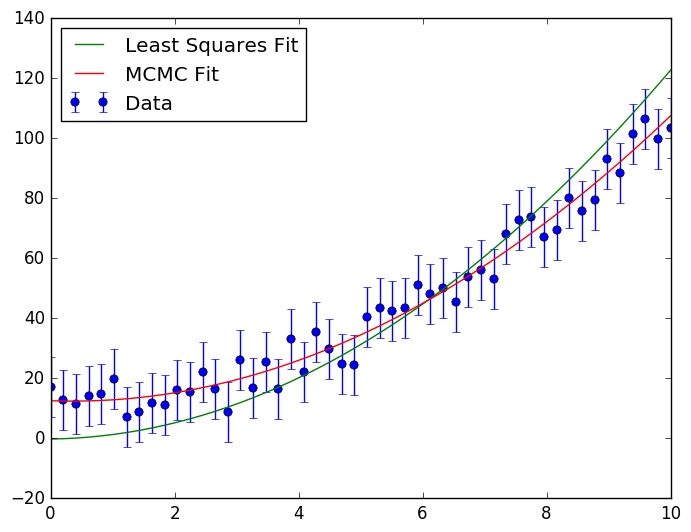

PyObject <matplotlib.legend.Legend object at 0x7f99d2db6650>

In [72]:
errorbar(x_data, y_data, y_error, fmt="o", label="Data")
plot(x_data, y_model, label="Least Squares Fit")
plot(x_data, y_model_mcmc, label="MCMC Fit")
legend(loc=2)

In [2]:
# Required packages
using LsqFit
using PyPlot
include("../compute_ttv.jl")
include("../ttv_succinct.jl")

ttv_succinct! (generic function with 1 method)

In [3]:
# Load transit timing data
transit_time1 = readdlm("../ttv_planet1.txt")[:,1]
transit_time2 = readdlm("../ttv_planet2.txt")[:,1]

transit_time1 .-= transit_time1[1]
transit_time2 .-= transit_time2[2]

24-element Array{Float64,1}:
 -365.26 
    0.0  
  365.255
  730.513
 1095.77 
 1461.02 
 1826.28 
 2191.54 
 2556.79 
 2922.05 
 3287.3  
 3652.56 
 4017.82 
 4383.08 
 4748.33 
 5113.59 
 5478.85 
 5844.1  
 6209.36 
 6574.61 
 6939.87 
 7305.12 
 7670.38 
 8035.64 

In [4]:
"""
# Calculates the total TTV at each time point for a
# set of planets.
#
# Input:
#   transit_time: A vector, with each element containing
#                 an array of transit times for one planet
#           pl: A vector of Planet_plane_hk objects
#
# Returns:
#   A vector, with each element containing the TTV offset
#   at every time point for the given planets
"""

function calc_ttv_total(transit_time::Vector, pl::Vector)
    N = length(pl)
    jmax = 20
    
    ttv_total = []
    for i=1:N
        append!(ttv_total, zeros(transit_time[i])) 
    end
    
    for i=1:N
        for j=(i+1):N
            ttv_i = zeros(length(transit_time[i]))
            ttv_j = zeros(length(transit_time[j]))
            TTVFaster.compute_ttv!(jmax, pl[i], pl[j], transit_time[i], transit_time[j], ttv_i, ttv_j)
            ttv_total[i] .+= ttv_i
            ttv_total[j] .+= ttv_j
        end
    end
    
    return ttv_total
end

calc_ttv_total (generic function with 1 method)

In [5]:
# Find approximate period from transit data
sum1 = 0.0
sum1a = 0.0
sum2 = 0.0
sum2a = 0.0
for i in 1:(length(transit_time1)-1)
    sum1 += transit_time1[i+1] - transit_time1[i]
end

Per1 = sum1 / (length(transit_time1)-1)

for i in 1:(length(transit_time1)-1)
    sum1a += (transit_time1[i+1] - transit_time1[i] - Per1)^2
end

for i in 1:(length(transit_time2)-1)
    sum2 += transit_time2[i+1] - transit_time2[i]
end


Per2 = sum2 / (length(transit_time2)-1)

for i in 1:(length(transit_time2)-1)
    sum2a += (transit_time2[i+1] - transit_time2[i] - Per2)^2
end

Stdev1 = sqrt(sum1a/(length(transit_time1)-1))
Stdev2 = sqrt(sum2a/(length(transit_time2)-1))

Per1,Per2,Stdev1,Stdev2

(224.70076641863517,365.25630708152175,0.0022543542095608466,0.0021310026275067444)

In [6]:
function timing_model_2p(x, p)
    m_rat1 = p[1]
    period1 = p[2]
    t01 = p[3]
    ecosw1 = p[4]
    esinw1 = p[5]
    
    m_rat2 = p[6]
    period2 = p[7]
    t02 = p[8]
    ecosw2 = p[9]
    esinw2 = p[10]
    
        # Mass ratios must be larger than zero
    if ((m_rat1 > 0.) && (m_rat2 > 0.) &&
        # Inner planets must have smaller periods
        (period1 > 0.) && (period1 < period2) &&
        # Keep periods within 1 standard deviation of the guess
        ((Per1 - 2.*Stdev1) < period1 < (Per1 + 2.*Stdev1)) &&
        ((Per1 - 2.*Stdev2) < period2 < (Per2 + 2.*Stdev2)) &&
        # Restruct ecc vector to be between -1 and 1 (and not 0)
        (ecosw1 != 0.) && (esinw1 != 0.) && (ecosw2 != 0.) && (esinw2 != 0.) &&
        (ecosw1 > -1.) && (esinw1 > -1.) && (ecosw2 > -1.) && (esinw2 > -1.) &&
        (ecosw1 < 1.) && (esinw1 < 1.) && (ecosw2 < 1.) && (esinw2 < 1.))
    
        t1 = collect(linspace(0., period1*length(transit_time1), length(transit_time1)))
        t2 = collect(linspace(0., period2*length(transit_time2), length(transit_time2)))
        
        pl = Array(TTVFaster.Planet_plane_hk{Float64}, 2)
        pl[1] = TTVFaster.Planet_plane_hk{Float64}(m_rat1, period1, t01, ecosw1, esinw1)
        pl[2] = TTVFaster.Planet_plane_hk{Float64}(m_rat2, period2, t02, ecosw2, esinw2)

        ttv_total = calc_ttv_total(Vector{Float64}[t1, t2], pl)
        
        t1 .+= ttv_total[1]
        t2 .+= ttv_total[2]

        retarr = collect([t1, t2])
        return retarr
    end

    t1 = collect(linspace(0., period1*length(transit_time1), length(transit_time1)))
    t2 = collect(linspace(0., period2*length(transit_time2), length(transit_time2)))
    retarr = zeros(length(t1)+length(t2))#collect([t1, t2])
    retarr[:] = typemax(Float64)
    return retarr
end

timing_model_2p (generic function with 1 method)

In [7]:
p = [1e-4, Per1, 0., 0.05, 0.05,
     1e-4, Per2, 0., 0.05, 0.05]

y = collect([transit_time1, transit_time2])
x = collect(linspace(1,length(y),length(y)))
weight = Array(Float64,length(y))
errorbars = Array(Float64,length(y))
weight[:] = (30.0/86400.0)^-2.
errorbars[:] = 30.0/86400.0
fit = curve_fit(timing_model_2p, x, y ,weight, p)
fit.param

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at ./abstractarray.jl:29
 in vect at abstractarray.jl:32
 in include_string at loading.jl:282
 in execute_request_0x535c5df2 at /astro/users/scw7/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /astro/users/scw7/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading In[7], in expression starting on line 4


10-element Array{Float64,1}:
   0.000115059
 224.697      
   0.232834   
   0.0484689  
   0.0385195  
   9.70572e-5 
 365.234      
   0.0332921  
   0.0512458  
   0.0586759  

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at ./abstractarray.jl:29
 in vect at abstractarray.jl:32
 in timing_model_2p at In[6]:38
 in f at /astro/users/scw7/.julia/v0.4/LsqFit/src/curve_fit.jl:45
 in levenberg_marquardt at /astro/users/scw7/.julia/v0.4/Optim/src/levenberg_marquardt.jl:38
 in lmfit at /astro/users/scw7/.julia/v0.4/LsqFit/src/curve_fit.jl:29
 in curve_fit at /astro/users/scw7/.julia/v0.4/LsqFit/src/curve_fit.jl:46
 in include_string at loading.jl:282
 in execute_request_0x535c5df2 at /astro/users/scw7/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /astro/users/scw7/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading In[7], in expression starting on line 10


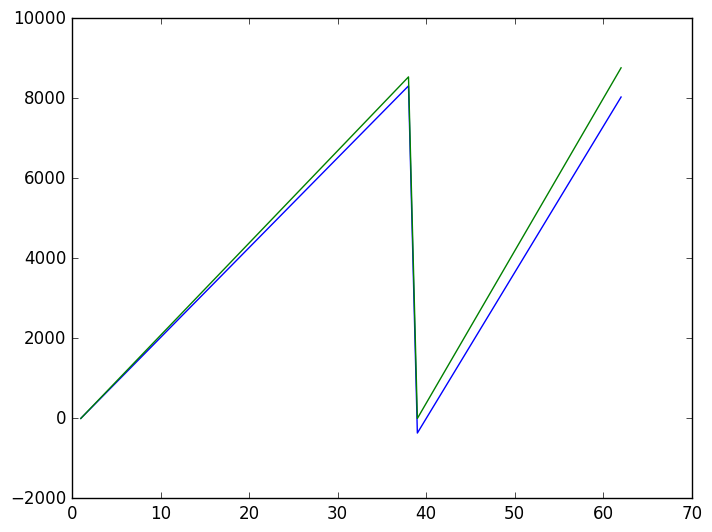

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f99d7a1e390>

In [10]:
x = collect(linspace(1., length(resid), length(resid)))
plot(x, collect([transit_time1, transit_time2]))

y_model = timing_model_2p(x, fit.param)
plot(x, y_model)

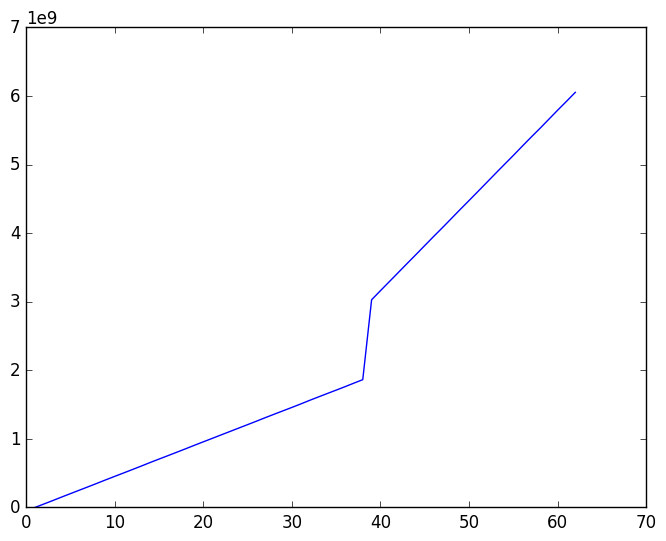

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f99d76a3410>

In [11]:
resid = fit.resid
x = collect(linspace(1., length(resid), length(resid)))
plot(x, resid)

In [78]:
function timing_model_3p_fixed_p3(x, p)
    m_rat1 = p[1]
    period1 = p[2]
    t01 = p[3]
    ecosw1 = p[4]
    esinw1 = p[5]
    
    m_rat2 = p[6]
    period2 = p[7]
    t02 = p[8]
    ecosw2 = p[9]
    esinw2 = p[10]
    
    m_rat3 = p[11]
    t03 = p[12]
    ecosw3 = p[13]
    esinw3 = p[14]
    
        # Mass ratios must be larger than zero
    if ((m_rat1 > 0.) && (m_rat2 > 0.) && (m_rat3 > 0.) &&
        # Inner planets must have smaller periods
        (period1 > 0.) && (period1 < period2) && (period2 < Period3) &&
        # Keep periods within 1 standard deviation of the guess
        ((Per1 - 2.*Stdev1) < period1 < (Per1 + 2.*Stdev1)) &&
        ((Per1 - 2.*Stdev2) < period2 < (Per2 + 2.*Stdev2)) &&
        # Restruct ecc vector to be between -1 and 1 (and not 0)
        (ecosw1 != 0.) && (esinw1 != 0.) && (ecosw2 != 0.) && (esinw2 != 0.) && (ecosw3 != 0. && esinw3 != 0.) &&
        (ecosw1 > -1.) && (esinw1 > -1.) && (ecosw2 > -1.) && (esinw2 > -1.) && (ecosw3 > -1. && esinw3 > -1.) &&
        (ecosw1 < 1.) && (esinw1 < 1.) && (ecosw2 < 1.) && (esinw2 < 1.) && (ecosw3 < 1. && esinw3 < 1.))
    
        t1 = collect(linspace(0., period1*length(transit_time1), length(transit_time1)))
        t2 = collect(linspace(0., period2*length(transit_time2), length(transit_time2)))
        t3 = collect(linspace(0., Period3*10., 10))
        
        pl = Array(TTVFaster.Planet_plane_hk{Float64}, 3)
        pl[1] = TTVFaster.Planet_plane_hk{Float64}(m_rat1, period1, t01, ecosw1, esinw1)
        pl[2] = TTVFaster.Planet_plane_hk{Float64}(m_rat2, period2, t02, ecosw2, esinw2)
        pl[3] = TTVFaster.Planet_plane_hk{Float64}(m_rat3, Period3, t03, ecosw3, esinw3)

        ttv_total = calc_ttv_total(Vector{Float64}[t1, t2, t3], pl)
        
        t1 .+= ttv_total[1]
        t2 .+= ttv_total[2]

        retarr = collect([t1, t2])
        return retarr
    end

    retarr = zeros(length(transit_time1)+length(transit_time2))
    retarr[:] = typemax(Float64)
    return retarr
end

timing_model_3p_fixed_p3 (generic function with 1 method)

In [79]:
periods = collect(linspace(4310.0,4340.0,30))
periods = [4329.]
chisq = zeros(Float64,length(periods))
fits = Array(Any,length(periods))

p = [1e-4, Per1, 0., 0.05, 0.05,
     1e-4, Per2, 0., 0.05, 0.05,
     1e-1,       0., 0.05, 0.05]

for i=1:length(periods)
    global Period3 = periods[i]
    transit_time3 = collect(linspace(0., periods[i]*10., 10))

    y = collect([transit_time1, transit_time2])
    x = collect(linspace(1,length(y),length(y)))
    weight = Array(Float64,length(y))
    errorbars = Array(Float64,length(y))
    weight[:] = (30.0/86400.0)^-2.
    errorbars[:] = 30.0/86400.0
    fit = curve_fit(timing_model_3p_fixed_p3, x, y ,weight, p)
    fits[i] = fit
    
    chisq[i] = sum((fit.resid/errorbars)^2.)
end

In [80]:
fits[indmin(chisq)].param

14-element Array{Float64,1}:
   0.000114987
 224.697      
   0.64949    
   0.0504217  
   0.0404065  
   9.70753e-5 
 365.234      
   0.567509   
   0.0515558  
   0.0596996  
   0.102352   
   8.50199    
   0.0659315  
   0.0783724  

In [81]:
x = collect(linspace(1., length(resid), length(resid)))
plot(x, collect([transit_time1, transit_time2]))

y_model = timing_model_3p_fixed_p3(x, fits[indmin(chisq)].param)
plot(x, y_model)

LoadError: LoadError: BoundsError: attempt to access 14-element Array{Float64,1}:
   0.000114987
 224.697      
   0.64949    
   0.0504217  
   0.0404065  
   9.70753e-5 
 365.234      
   0.567509   
   0.0515558  
   0.0596996  
   0.102352   
   8.50199    
   0.0659315  
   0.0783724  
  at index [15]
while loading In[81], in expression starting on line 4

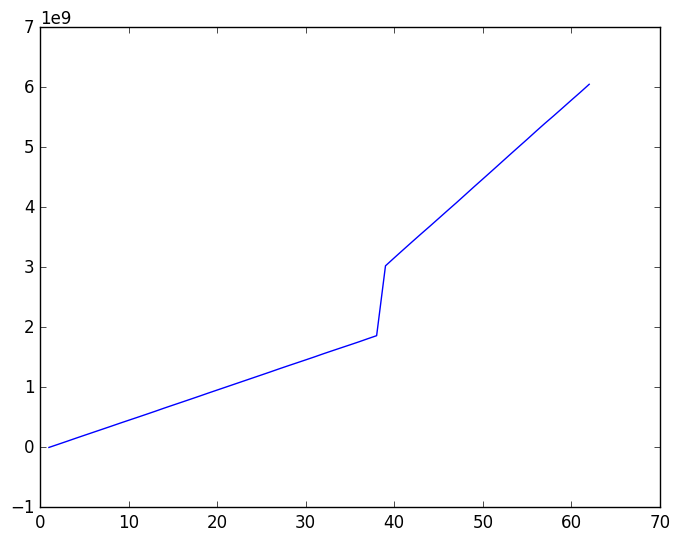

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f99d2cdcd10>

In [82]:
resid = fits[indmin(chisq)].resid
x = collect(linspace(1., length(resid), length(resid)))
plot(x, resid)

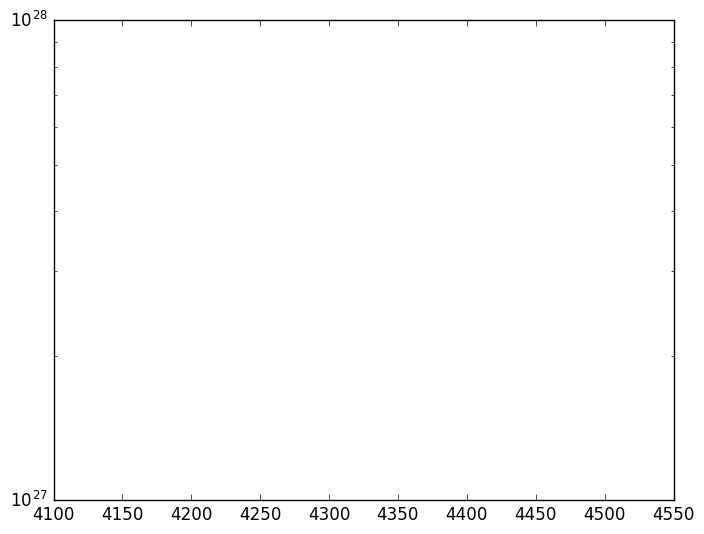

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f99d2d10a90>

In [83]:
semilogy(periods,chisq)

In [84]:
function timing_model_3p(x, p)
    m_rat1 = p[1]
    period1 = p[2]
    t01 = p[3]
    ecosw1 = p[4]
    esinw1 = p[5]
    
    m_rat2 = p[6]
    period2 = p[7]
    t02 = p[8]
    ecosw2 = p[9]
    esinw2 = p[10]
    
    m_rat3 = p[11]
    period3 = p[12]
    t03 = p[13]
    ecosw3 = p[14]
    esinw3 = p[15]
    
        # Mass ratios must be larger than zero
    if ((m_rat1 > 0.) && (m_rat2 > 0.) && (m_rat3 > 0.) &&
        # Inner planets must have smaller periods
        (period1 > 0.) && (period1 < period2) && (period2 < period3) &&
        # Keep periods within 1 standard deviation of the guess
        ((Per1 - 2.*Stdev1) < period1 < (Per1 + 2.*Stdev1)) &&
        ((Per1 - 2.*Stdev2) < period2 < (Per2 + 2.*Stdev2)) &&
        # Restruct ecc vector to be between -1 and 1 (and not 0)
        (ecosw1 != 0.) && (esinw1 != 0.) && (ecosw2 != 0.) && (esinw2 != 0.) && (ecosw3 != 0. && esinw3 != 0.) &&
        (ecosw1 > -1.) && (esinw1 > -1.) && (ecosw2 > -1.) && (esinw2 > -1.) && (ecosw3 > -1. && esinw3 > -1.) &&
        (ecosw1 < 1.) && (esinw1 < 1.) && (ecosw2 < 1.) && (esinw2 < 1.) && (ecosw3 < 1. && esinw3 < 1.))
    
        t1 = collect(linspace(0., period1*length(transit_time1), length(transit_time1)))
        t2 = collect(linspace(0., period2*length(transit_time2), length(transit_time2)))
        t3 = collect(linspace(0., Period3*10., 10))
        
        pl = Array(TTVFaster.Planet_plane_hk{Float64}, 3)
        pl[1] = TTVFaster.Planet_plane_hk{Float64}(m_rat1, period1, t01, ecosw1, esinw1)
        pl[2] = TTVFaster.Planet_plane_hk{Float64}(m_rat2, period2, t02, ecosw2, esinw2)
        pl[3] = TTVFaster.Planet_plane_hk{Float64}(m_rat3, period3, t03, ecosw3, esinw3)

        ttv_total = calc_ttv_total(Vector{Float64}[t1, t2, t3], pl)
        
        t1 .+= ttv_total[1]
        t2 .+= ttv_total[2]

        retarr = collect([t1, t2])
        return retarr
    end

    retarr = zeros(length(transit_time1)+length(transit_time2))
    retarr[:] = typemax(Float64)
    return retarr
end

timing_model_3p (generic function with 1 method)

In [95]:
y = collect([transit_time1, transit_time2])
x = collect(linspace(1, length(y), length(y)))

y_error = Array(Float64,length(y))
y_error[:] = 30.0/86400.0

lsq_fit_params = fits[indmin(chisq)].param
lsq_fit_params_15 = zeros(15)

for i=1:14
    if i < 12
        lsq_fit_params_15[i] = lsq_fit_params[i]
        elseif i > 12
            lsq_fit_params_15[i+1] = lsq_fit_params[i]
        end
end
lsq_fit_params_15[12] = periods[indmin(chisq)]

param_errors = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
chi_best = chisq[indmin(chisq)]

param_mean = zeros(15)
param_std = zeros(15)

mcmc_fit!(timing_model_3p, x, y, y_error, lsq_fit_params_15, param_errors, chi_best, param_mean, param_std)

Success: [1.1541192748055658,224.70027299070472,1.5041273914246953,-0.08960770235093268,-0.6955287286437001,0.464181279340535,365.21917882466886,0.926137250731218,-0.07942369537294541,0.5861832671565648,1.1226672979816357,4327.564116837182,-0.2718449059934757,-0.698698606246895,-0.27708238341574876]1.4385062232985147e17
Success: [0.3456863507736254,224.70160479921861,-0.6432651192042916,0.25237995347588704,0.7959693991882609,0.06329639882266072,364.8477719901365,-0.13192639917287075,-0.7866885946265559,-0.2313451158464424,0.14473698876093452,4328.459928392273,1.1453616054649451,0.669722765567489,-0.3955204777332373]1.7043519229464936e16
Success: [0.9369975887376927,224.70010420603856,0.0008089420949271009,-0.6112619919715477,-0.024397014244133458,2.0429013405729695,364.0428212917895,1.2464442193229754,-0.35022099751673597,0.5473971726865853,0.046740259308201616,4325.868763385873,-2.2875581862240915,0.1794302459599149,0.45976008019322756]1.0966184667309598e17
Success: [1.82688407561122,

In [97]:
param_mean

15-element Array{Float64,1}:
    0.000924061
  224.7        
  -16.5427     
    0.807081   
    0.81355    
    0.000544709
  350.447      
  -29.77       
   -0.583098   
   -0.649645   
   11.5748     
 4343.7        
   14.9025     
    0.064152   
    0.534325   